# Importação das Bibliotecas

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

In [111]:
players = pd.read_csv('players_merged.csv')

In [112]:
players.describe()

,matches_count,wins_count,easy_wins_count,defeated_count,easy_defeated_count,tied,score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,19.998900,9.948400,6.040100,9.948400,6.040100,0.102100,0.499494
std,4.459943,3.114435,2.432382,3.177664,2.450733,0.315413,0.114237
min,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.062500
25%,17.000000,8.000000,4.000000,8.000000,4.000000,0.000000,0.423077
50%,20.000000,10.000000,6.000000,10.000000,6.000000,0.000000,0.500000
75%,23.000000,12.000000,8.000000,12.000000,8.000000,0.000000,0.576923
max,37.000000,24.000000,20.000000,25.000000,17.000000,3.000000,1.000000


In [113]:
players.head()

,player_id,matches_count,wins_count,easy_wins_count,defeated_count,easy_defeated_count,tied,score,player_name,email,country,last_login
0,DA1X9864,24.0,9.0,4.0,15.0,9.0,0.0,0.375000,Trisha Kessler,trisha_kessler@gmail.com,Myanmar (Burma),2020-11-12
1,SZ0S2637,22.0,14.0,10.0,8.0,6.0,0.0,0.636364,Tangela Graver,tangela_g@gmail.com,Marshall Islands,2020-12-11
2,QX0H6977,20.0,11.0,7.0,8.0,7.0,1.0,0.566667,Eliseo Ewald,eliseo_ewald@gmail.com,Italy,2020-12-20
3,BK3W3327,14.0,11.0,6.0,3.0,3.0,0.0,0.785714,Bernardo Dieterich,dieterich.b@gmail.com,Cambodia,2020-10-11
4,EG5I9716,22.0,12.0,9.0,10.0,7.0,0.0,0.545455,Maurice Wilcoxson,wilcoxson_m@gmail.com,Marshall Islands,2020-12-11


# Definindo as variáveis mais importantes

### Levando em conta que queremos agrupar os jogadores por níveis, as variáveis mais relevantes e que levaremos em consideração no agrupamento são:
* Número de Partidas;
* Número de goleadas aplicadas;
* Número de goleadas sofridas;
* Porcentagem de aproveitamento dos pontos;

### Separando as variáveis e aplicando o escalonamento dos valores

In [114]:
variables = ['matches_count', 'easy_wins_count', 'easy_defeated_count', 'score']

In [115]:
X = players[variables].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 1.KMeans

## Definindo o número de clusters

In [116]:
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

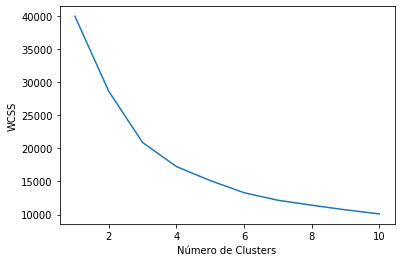

In [117]:
plt.plot(range(1,11), wcss)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

De acordo com o gráfico, o número de clusters ideal é 3 ou 4, pois são os pontos onde o valor WCSS começa a se estabilizar

## Treinando o Modelo

In [118]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_predict = kmeans.fit_predict(X)

In [119]:
players_predicted = np.column_stack((players, kmeans_predict))
predicted_df = pd.DataFrame(players_predicted)

In [120]:
X_inverse = scaler.inverse_transform(X)

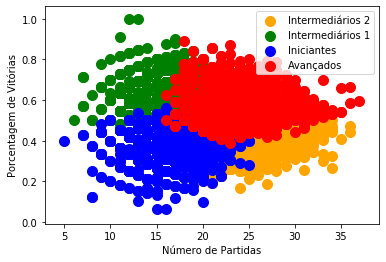

In [121]:
def kmeans_plot():
    plt.scatter(X_inverse[kmeans_predict == 0, 0], X_inverse[kmeans_predict == 0, 3], s=100, c='orange', label='Intermediários 2')
    plt.scatter(X_inverse[kmeans_predict == 1, 0], X_inverse[kmeans_predict == 1, 3], s=100, c='green', label='Intermediários 1')
    plt.scatter(X_inverse[kmeans_predict == 3, 0], X_inverse[kmeans_predict == 3, 3], s=100, c='blue', label='Iniciantes')
    plt.scatter(X_inverse[kmeans_predict == 2, 0], X_inverse[kmeans_predict == 2, 3], s=100, c='red', label='Avançados')
    plt.xlabel('Número de Partidas')
    plt.ylabel('Porcentagem de Vitórias')
    plt.legend()

kmeans_plot()

### Resultado:

De acordo com o gráfico, encontramos 3 grupos que podemos classificar como: 
* **Iniciantes**: jogadores com número de partidas baixo e com um aproveitamento de vitórias baixo/médio;
* **Intermediários 1**: jogadores com número de partidas baixo e com um aproveitamento de vitórias médio/alto;
* **Intermediários 2**: jogadores com número de partidas alto e aproveitamento de vitórias baixo/médio;
* **Avançados**: jogadores com número de jogos médio/alto e porcentagem de vitórias médio/alto.

## Exportando classificações

In [122]:
players.columns

Index(['player_id', 'matches_count', 'wins_count', 'easy_wins_count',
       'defeated_count', 'easy_defeated_count', 'tied', 'score', 'player_name',
       'email', 'country', 'last_login'],
      dtype='object')

In [123]:
predicted_df.columns = ['player_id', 'matches_count', 'wins_count', 'easy_wins_count',
       'defeated_count', 'easy_defeated_count', 'tied', 'score', 'player_name',
       'email', 'country', 'last_login', 'level']

In [124]:
for index, row in predicted_df.iterrows():
    if row['level'] == 0:
        predicted_df.at[index, 'level'] = 'advanced'
    elif row['level'] == 1:
        predicted_df.at[index, 'level'] = 'intermediate'
    elif row['level'] == 2:
        predicted_df.at[index, 'level'] = 'expert'
    elif row['level'] == 3:
        predicted_df.at[index, 'level'] = 'beginner'

In [125]:
predicted_df.to_csv('players_classified.csv', index=False)

# 2.Agrupamento Hierárquico

## Definindo o número de clusters

Text(0.5, 1.0, 'Dendograma')

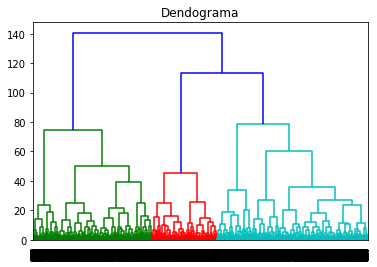

In [126]:
dendograma = dendrogram(linkage(X, method='ward'))
plt.title('Dendograma')

O dendograma nos mostra que o número ideal de clusters é 3 ou 4

## Treinando do modelo

In [127]:
hc = AgglomerativeClustering(n_clusters=4)
agg_predict = hc.fit_predict(X)

In [128]:
X_inverse = scaler.inverse_transform(X)

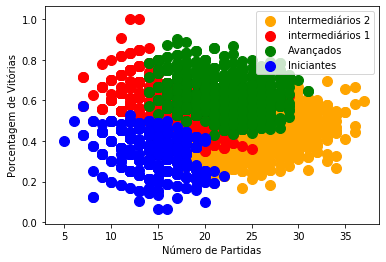

In [129]:
def agg_plot():
    plt.scatter(X_inverse[agg_predict == 0, 0], X_inverse[agg_predict == 0, 3], s=100, c='orange', label='Intermediários 2')
    plt.scatter(X_inverse[agg_predict == 1, 0], X_inverse[agg_predict == 1, 3], s=100, c='red', label='intermediários 1')
    plt.scatter(X_inverse[agg_predict == 2, 0], X_inverse[agg_predict == 2, 3], s=100, c='green', label='Avançados')
    plt.scatter(X_inverse[agg_predict == 3, 0], X_inverse[agg_predict == 3, 3], s=100, c='blue', label='Iniciantes')
    plt.xlabel('Número de Partidas')
    plt.ylabel('Porcentagem de Vitórias')
    plt.legend()

agg_plot()

### Resultado:

A classificação do Agrupamento Hierárquico ficou parecido com o KMEANS, porém a divisão não ficou tão precisa:

* **Iniciantes**: jogadores com número de partidas baixo e com um aproveitamento de vitórias baixo/médio;
* **Intermediários 1**: jogadores com número de partidas baixo e com um aproveitamento de vitórias médio/alto;
* **Intermediários 2**: jogadores com número de partidas alto e aproveitamento de vitórias baixo/médio;
* **Avançados**: jogadores com número de jogos médio/alto e porcentagem de vitórias médio/alto.


# 3.DBSCAN

## Treinando o modelo

In [130]:
dbscan = DBSCAN(eps=1, min_samples=1)
dbscan_predict = dbscan.fit_predict(X)

## Verificando quantidade de clusters encontrados para ajuste dos parâmetros

In [131]:
predict_unique, count = np.unique(dbscan_predict, return_counts=True)
print('Unicos: {} - Quantidade: {}'.format(predict_unique, count))

Unicos: [0 1 2 3 4 5 6 7] - Quantidade: [9993    1    1    1    1    1    1    1]


In [132]:
X_inverse = scaler.inverse_transform(X)

No handles with labels found to put in legend.


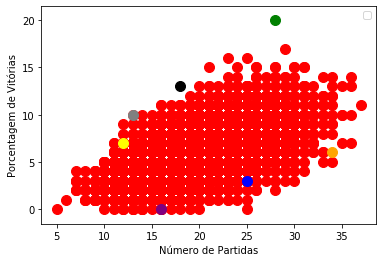

In [133]:
def dbscan_plot():
  plt.scatter(X_inverse[dbscan_predict == 0, 0], X_inverse[dbscan_predict == 0, 1], s=100, c='red')
  plt.scatter(X_inverse[dbscan_predict == 1, 0], X_inverse[dbscan_predict == 1, 1], s=100, c='orange')
  plt.scatter(X_inverse[dbscan_predict == 2, 0], X_inverse[dbscan_predict == 2, 1], s=100, c='green')
  plt.scatter(X_inverse[dbscan_predict == 3, 0], X_inverse[dbscan_predict == 3, 1], s=100, c='grey')
  plt.scatter(X_inverse[dbscan_predict == 4, 0], X_inverse[dbscan_predict == 4, 1], s=100, c='black')
  plt.scatter(X_inverse[dbscan_predict == 5, 0], X_inverse[dbscan_predict == 5, 1], s=100, c='yellow')
  plt.scatter(X_inverse[dbscan_predict == 6, 0], X_inverse[dbscan_predict == 6, 1], s=100, c='blue')
  plt.scatter(X_inverse[dbscan_predict == 7, 0], X_inverse[dbscan_predict == 7, 1], s=100, c='purple')
  plt.xlabel('Número de Partidas')
  plt.ylabel('Porcentagem de Vitórias')
  plt.legend()

dbscan_plot()

### Resultado:

Depois de inúmeros testes com o algoritmo DBSCAN, o gráfico mostra que ele não foi eficiente na busca por grupos e classificou a grande maioria em um único grupo.

# Jogadores agrupados por países

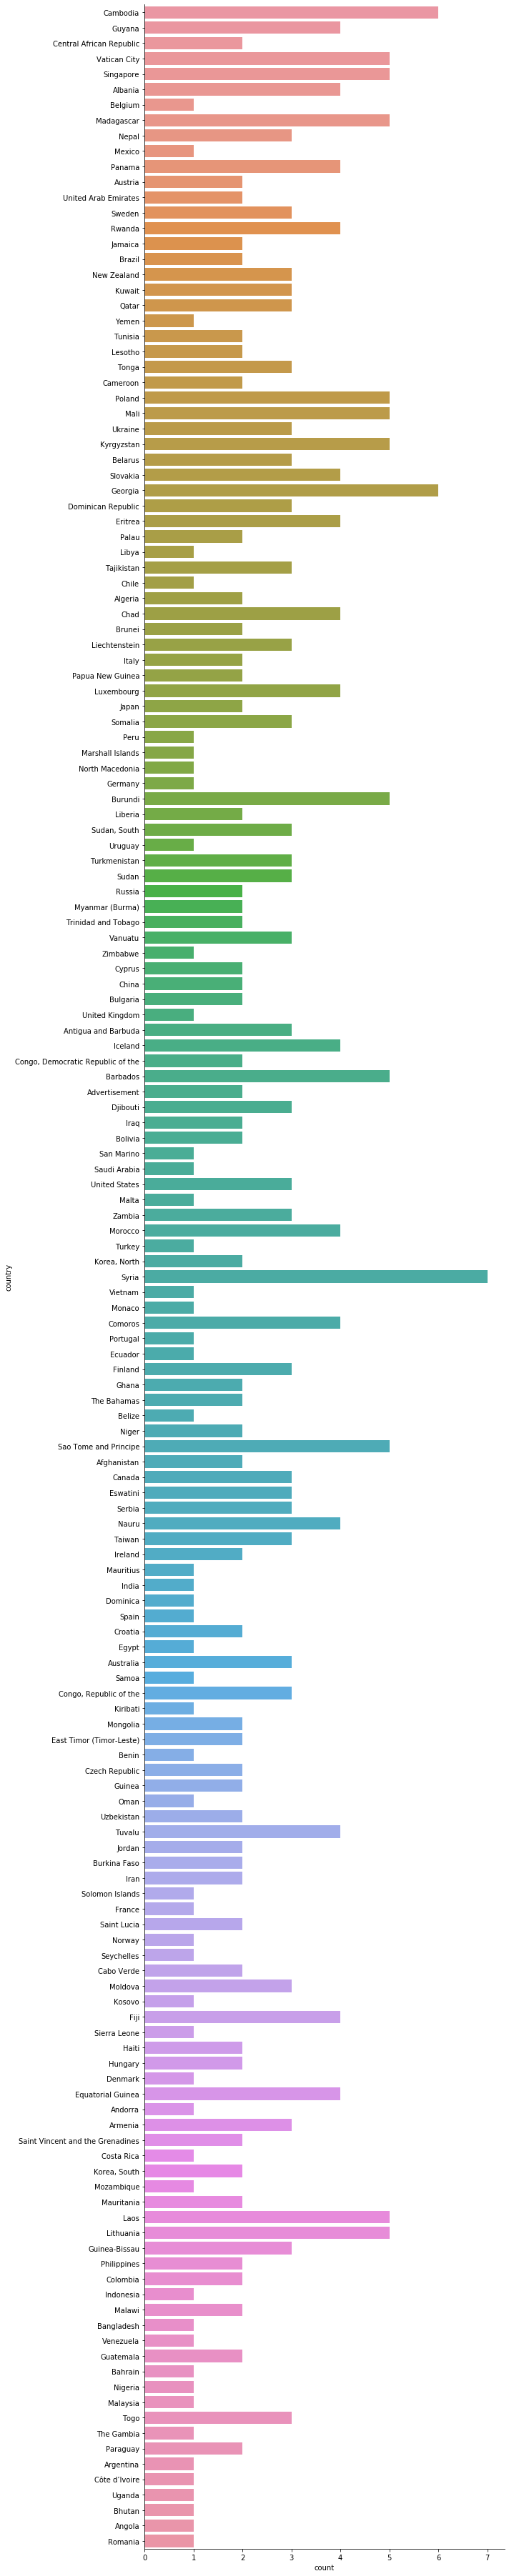

In [134]:
players_by_country = players.query('score > 0.7')[['score', 'country']]
sns.catplot(y="country", kind="count", data=players_by_country, height=50, aspect=0.2)

# O gráfico reprenta o número de jogadores com aproveitamento superior a 70% agrupados por país.

## Logo, podemos verificar um destaque em jogadores dos países: 
* Síria
* Georgia
* Cambodia

## Com destaque para jogadores da Síria.

# Conclusão

## O algoritmo com melhor resultado foi o K-MEANS, pois ele identificou melhor a separação dos grupos.

## GRUPOS FORMADOS:
* **Iniciantes**: jogadores com poucas partidas e com um aproveitamento de vitórias baixo/médio;
* **Intermediários**: jogadores com mais partidas e aproveitamento de vitórias médio;
* **Avançados**: jogadores com maior porcentagem de vitórias e número de jogos baixos/médios.

# Próximo Passo

## Gerar dados com a classificação gerada de cada jogador na base existente e treinar outro modelo para classificação de novos jogadores (arquivo classificacao.ipynb)